### 数据准备

In [2]:
import tushare as ts
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np

ts.set_token('5f74ec7e9d0e71e8b8174fc48550635013e084a53d63af4cac832ab3')
pro = ts.pro_api()

stock = '002547'
start_date = '20190201'
end_date = (date.today() - timedelta(days=1)).strftime('%Y%m%d')

# 获取该股票的所有分时数据
def getTickData(tick_date, stock):
    df = ts.get_tick_data(stock, date=tick_date,src='tt')
    df['day_date'] = tick_date
    return df

# 获取所有交易日期
df_date = pro.trade_cal(exchange='', start_date=start_date, end_date=end_date)
date_list = df_date[df_date['is_open'] == 1].cal_date.values

In [17]:
# 获取所有日期的分时数据
total_num = len(date_list)
n = 1
df_list = []
for i in date_list:
    if n % 10 == 0:
        print(str(n) + '/' + str(total_num))
    # 转化日期格式
    stock_date = datetime.strptime(i, '%Y%m%d').strftime('%Y-%m-%d')
    # 9:40 增量 9:50 增量 10:00 增量
    df = getTickData(stock_date, stock)
    df_list.append(df)
    n += 1

10/203
20/203
30/203
40/203
50/203
60/203
70/203
80/203
90/203
100/203
110/203
120/203
130/203
140/203
150/203
160/203
170/203
180/203
190/203
200/203


In [18]:
df_res = pd.concat(df_list, axis=0)
df_res.to_csv('./stock_tick.csv', encoding='utf-8-sig')

In [3]:
# 从csv中获取分时数据
df_res = pd.read_csv('./stock_tick.csv')
df_res.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

def getLastTradeDate(day_date, n):
    #获取上一个交易日日期
    index = list(date_list).index(day_date.replace('-', '')) + n
    if index > (len(date_list) - 1):
        return ''
    else:
        return datetime.strptime(date_list[index], '%Y%m%d').strftime('%Y-%m-%d')

In [4]:
# 9点半之前增量
df1 = df_res[df_res['time'] < '09:30:00'].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'bid'})
# 9:30 - 9:40
df2 = df_res[(df_res['time'] < '09:40:00') & (df_res['time'] >= '09:30:00')].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'm10'})
# 9:40 - 9:50
df3 = df_res[(df_res['time'] < '09:50:00') & (df_res['time'] >= '09:40:00')].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'm20'})
# 9:50 - 10:00
df4 = df_res[(df_res['time'] < '10:00:00')  & (df_res['time'] >= '09:50:00')].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'm30'})
# 10点总量
df5 = df_res[df_res['time'] < '10:00:00'].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'b10'})

# 昨天总量
df6 = df_res.groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'total'}).reset_index()
df_yesterday_total = pd.concat([df6['day_date'].apply(getLastTradeDate, args=(1,)), df6.total], axis=1).set_index('day_date').rename(columns={'total': 'yesterday_total'})
dyt = df_yesterday_total[df_yesterday_total.index != '']
# 昨天10点前的增量
df7 = df_res[df_res['time'] < '10:00:00'].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'total'}).reset_index()
df_yesterday_b10 = pd.concat([df7['day_date'].apply(getLastTradeDate, args=(1,)), df7.total], axis=1).set_index('day_date').rename(columns={'total': 'yesterday_b10'})
dyb10 = df_yesterday_b10[df_yesterday_b10.index != '']
# 前天总量
df8 = df_res.groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'total'}).reset_index()
df_tdby_total = pd.concat([df8['day_date'].apply(getLastTradeDate, args=(2,)), df8.total], axis=1).set_index('day_date').rename(columns={'total': 'tdby_total'})
dtt = df_tdby_total[df_tdby_total.index != '']
# 前天10点半前的增量
df9 = df_res[df_res['time'] < '10:00:00'].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'total'}).reset_index()
df_tdby_b10 = pd.concat([df9['day_date'].apply(getLastTradeDate, args=(2,)), df9.total], axis=1).set_index('day_date').rename(columns={'total': 'tdby_b10'})
dtb10 = df_tdby_b10[df_tdby_b10.index != '']

In [55]:
# 组装x
df_11 = df1.join(df2).join(df3).join(df4).join(df5).join(dyt).join(dyb10).join(dtt).join(dtb10)
df_x = df_11[df_11.index > '2019-02-11']
data_x_list = []
for i in df_x.index:
#     data_x_list.append(list(df_x.loc[i].values))
    data_x_list.append([df_x.loc[i].b10, df_x.loc[i].yesterday_total])
data_x = np.array(data_x_list)
# 组装y
df_y = df_res[df_res['day_date'] > '2019-02-11'].groupby('day_date').agg({'volume': 'sum'}).rename(columns={'volume': 'total'})
data_y = df_y.total.values / 10000

### 机器学习模型建立

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import os
import sys
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

In [86]:
# 数据切分
x_train_all, x_test, y_train_all, y_test = train_test_split(
    data_x, data_y, random_state=7, test_size=0.1
)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all
)

# 数据归一化
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler = scaler.transform(x_test)

In [87]:
# 建立模型 
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=x_train_scaler.shape[1:]),
    tf.keras.layers.Dense(1)
#     tf.keras.layers.Dense(1, activation='relu'),
])
# 编译模型sparse_categorical_crossentropy
model.compile(loss='mean_squared_error',
              optimizer = 'sgd'
             )
# 设置回调函数
logdir = '.\\callbacks'

if not os.path.exists(logdir):
    os.mkdir(logdir)

output_model_file = os.path.join(logdir, 'stockVolumePredict.h5')

callbacks = [
    tf.keras.callbacks.TensorBoard(logdir),
    tf.keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train, y_train, epochs=1000,
                    validation_data=(x_valid, y_valid),
                   callbacks=callbacks)

Train on 135 samples, validate on 46 samples
Epoch 1/1000
135/135 [==============================] - 0s 3ms/sample - loss: inf - val_loss: nan
Epoch 2/1000
135/135 [==============================] - 0s 604us/sample - loss: nan - val_loss: nan
Epoch 3/1000
135/135 [==============================] - 0s 553us/sample - loss: nan - val_loss: nan
Epoch 4/1000
 32/135 [======>.......................] - ETA: 0s - loss: nan

d:\workspace\env\py3env\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):
d:\workspace\env\py3env\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


135/135 [==============================] - 0s 605us/sample - loss: nan - val_loss: nan
Epoch 5/1000
135/135 [==============================] - 0s 609us/sample - loss: nan - val_loss: nan


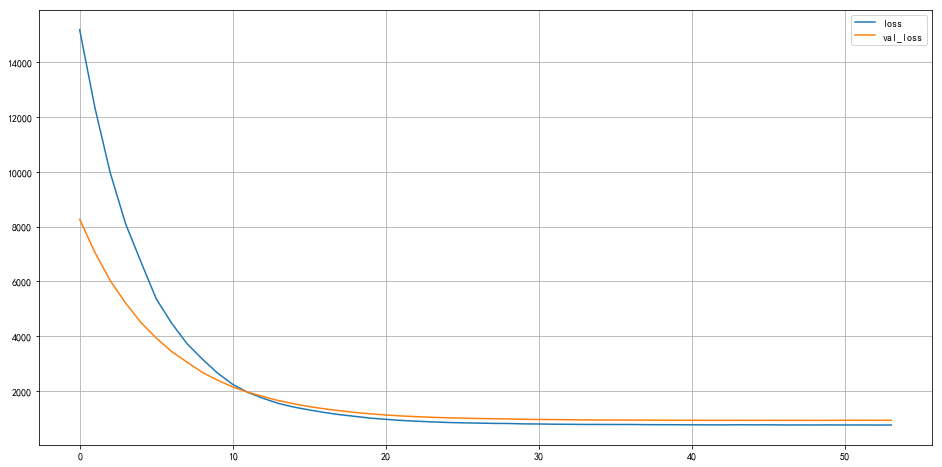

In [75]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(16, 8))
    plt.grid(True)
    # plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [76]:
model.evaluate(x_test_scaler, y_test)

21/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 117us/sample - loss: 1398.8568


1398.8568115234375

In [83]:
n = -1
data_x[n], data_y[n]

(array([105960., 440668.]), 57.0869)

In [84]:
# model.predict([data_x[1]])
model.predict(np.array([data_x[n]]))

array([[15483685.]], dtype=float32)